In [34]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats
import time as time
from sklearn.linear_model import LinearRegression
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


**WARNING FOR THE USER**: 

Most of the cells, especially in exercise 2, were run using an **NVIDIA A100 GPU** from Colab. This includes the **MBRC Callable pricing** section, which requires more epochs to be trained. 

If you plan to test the behavior using a machine with **less than 32 GB of RAM**, it is recommended to avoid using a `n_batch` parameter greater than **300-400** to prevent performance issues. One can also decrease the parameters `J`, `test_total_paths` and `test_upper_total_paths` that represent the parameters $J$, $K_L$ and $K_U$ in the report, respectively.

Please note that the execution times for **part 2** were measured on this high-performance environment, which offers a significant speedup compared to running the code on less powerful GPUs or CPUs. 

For reference:
- **NVIDIA 3050 Ti GPU**: The code will take approximately **2-3 times longer**.
- **AMD 5800H CPU**: The code will take up to **5-10 times longer**.


## EXERCISE 1

In [3]:
def generate_stock_paths(n_sim, rf, sigma, T, S_0):

    W_T = np.sqrt(T)*np.random.normal(0,1, n_sim)

    X_T = ((rf-((sigma*sigma)/2))*T + sigma*W_T)

    S_T = S_0 *np.exp(X_T)

    return X_T, S_T, W_T

In [4]:
def smooth_barrier(epsilon, msT, B):
    return np.where(
        msT <= B - epsilon / 2,
        0,
        np.where(
            msT >= B + epsilon / 2,
            1,
            (msT - (B - epsilon / 2)) / epsilon
        )
    )

In [5]:
def delta_barrier_down_and_out(n_sim, rf, sigma, T, S_0, K, epsilon, B):

    X_T, S_T, _ = generate_stock_paths(n_sim, rf, sigma, T, S_0)

    U = np.random.uniform(0,1,n_sim)

    mxT = 0.5 * (X_T - np.sqrt(X_T*X_T - 2*sigma*sigma*T*np.log(U)))

    msT = S_0*np.exp(mxT)

    barrier_value = smooth_barrier(epsilon, msT, B)
    term1 = barrier_value*np.where(S_T> K, 1, 0)*(S_T/S_0)
    term2 = np.where(S_T > K, S_T - K, 0)*np.where((msT >= B - epsilon / 2) & (msT <= B + epsilon / 2), 1, 0)*(1/epsilon)*(msT/S_0)

    deltas = np.exp(-rf*T)*(term1 + term2)

    return deltas


In [6]:
n_sim, rf, sigma, T, S_0, K, epsilon, B = 10**8, 0.05, 0.5, 1, 100, 110, 0.001, 90

In [ ]:
np.random.seed(0)
deltas = delta_barrier_down_and_out(n_sim, rf, sigma, T, S_0, K, epsilon, B)

In [ ]:
print(np.mean(deltas), np.std(deltas, ddof=1)/np.sqrt(n_sim))

0.847063684913986 0.024463408399958364


In [ ]:
def vega_barrier_down_and_out(n_sim, rf, sigma, T, S_0, K, epsilon, B):

    X_T, S_T, W_T = generate_stock_paths(n_sim, rf, sigma, T, S_0)

    U = np.random.uniform(0,1,n_sim)

    logU = np.log(U)

    #Barrier crossing trick.
    root_minimum = np.sqrt(X_T*X_T - 2*sigma*sigma*T*logU)
    mxT = 0.5 * (X_T - root_minimum)

    msT = S_0*np.exp(mxT)

    barrier_value = smooth_barrier(epsilon, msT, B)
    dXsigma = -sigma*T + W_T
    dMinXSigma = 0.5*(dXsigma - ((X_T*dXsigma - 2*sigma*T*logU)/root_minimum))
    dMinSSigma = dMinXSigma*msT

    term1 = barrier_value*np.where(S_T> K, 1, 0)*S_T*dXsigma
    term2 = np.where(S_T > K, S_T - K, 0)*np.where((msT >= B - epsilon / 2) & (msT <= B + epsilon / 2), 1, 0)*(1/epsilon)*dMinSSigma

    vegas = np.exp(-rf*T)*(term1 + term2)
    return vegas


In [ ]:
n_sim, rf, sigma, T, S_0, K, epsilon, B

(100000000, 0.05, 0.5, 1, 100, 110, 0.001, 90)

In [ ]:
vegas = vega_barrier_down_and_out(n_sim, rf, 0.5, T, S_0, K, epsilon, B)

In [ ]:
print(np.mean(vegas), np.std(vegas, ddof=1)/np.sqrt(n_sim))

4.601698706828971 0.600018845125719


#### VARIANCE REDUCTION: ANTITHETIC SAMPLING

In [ ]:
def generate_stock_paths_vega(n_sim, rf, sigma, T, S_0):

    W_T_1 = np.sqrt(T)*np.random.normal(0,1, n_sim)
    W_T_2 = W_T_1 * (-1)

    X_T_1 = ((rf-((sigma*sigma)/2))*T + sigma*W_T_1)
    X_T_2 = ((rf-((sigma*sigma)/2))*T + sigma*W_T_2)
    
    S_T_1 = S_0 *np.exp(X_T_1)
    S_T_2 = S_0 *np.exp(X_T_2)

    return [X_T_1, S_T_1, W_T_1], [X_T_2, S_T_2, W_T_2]

In [ ]:
def vega_barrier_down_and_out(n_sim, rf, sigma, T, S_0, K, epsilon, B):

    path_1, path_2 = generate_stock_paths_vega(n_sim, rf, sigma, T, S_0)

    U_1 = np.random.uniform(0,1,n_sim)
    U_2 = 1 - U_1

    vegas = np.array([])    

    for path in [path_1, path_2]:
        for U in [U_1, U_2]:
            
            X_T, S_T, W_T = path
    
            logU = np.log(U)
        
            root_minimum = np.sqrt(X_T*X_T - 2*sigma*sigma*T*logU)
            mxT = 0.5 * (X_T - root_minimum)
        
            msT = S_0*np.exp(mxT)
        
            barrier_value = smooth_barrier(epsilon, msT, B)
            dXsigma = -sigma*T + W_T
            dMinXSigma = 0.5*(dXsigma - ((X_T*dXsigma - 2*sigma*T*logU)/root_minimum))
            dMinSSigma = dMinXSigma*msT
        
            term1 = barrier_value*np.where(S_T> K, 1, 0)*S_T*dXsigma
            term2 = np.where(S_T > K, S_T - K, 0)*np.where((msT >= B - epsilon / 2) & (msT <= B + epsilon / 2), 1, 0)*(1/epsilon)*dMinSSigma
        
            vegas_sim = np.exp(-rf*T)*(term1 + term2)

            vegas = np.concatenate((vegas, vegas_sim))
    
    return vegas


In [ ]:
vegas = vega_barrier_down_and_out(n_sim, rf, sigma, T, S_0, K, epsilon, B)
print(np.mean(vegas), np.std(vegas, ddof=1)/np.sqrt(4*n_sim))

## EXERCISE 2

## BERMUDEAN MAX CALL

In [7]:
r = 0.05
dividend = 0.1
sigma = 0.2
S0 = 100.0
K = 100.0
T =3.0
N = 9
h=T/N
batch_size = 8192
learning_rate = 0.001

In [8]:
def generate_GBM_paths(d, rf, dividend, sigma, S0, T, N, h, total_paths,rho=None):

    h = T/N
    t = np.arange(0, N+1) * h
    dW = np.random.randn(total_paths, d, N) * np.sqrt(h)
    if rho is not None:
        L = np.linalg.cholesky(rho) # Apply Cholesky decomposition to introduce correlation
        dW = np.einsum('ij,pjn->pin', L, dW)
    W = np.cumsum(dW, axis=2)
    W = np.concatenate([np.zeros((total_paths, d, 1)), W], axis=2)
    mu = rf - dividend
    St = S0 * np.exp((mu - 0.5 * sigma ** 2)*t + sigma*W)
    return St


In [9]:
def generate_GBM_paths_asym(d, rf, dividend, S0, T, N, h, total_paths,rho=None):

    h = T/N
    if d<2:
        sigma=0.2
    elif d<6:
        sigma = [0.08 + 0.32*(i-1)/(d-1) for i in range(1,d+1)]
    else:
        sigma = [0.1 + i/(2*d) for i in range(1, d+1)]
    sigma = np.array(sigma)
    t = np.arange(0, N+1) * h
    dW = np.random.randn(total_paths, d, N) * np.sqrt(h)
    if rho is not None:
        L = np.linalg.cholesky(rho) # Apply Cholesky decomposition to introduce correlation
        dW = np.einsum('ij,pjn->pin', L, dW)
    W = np.cumsum(dW, axis=2)
    W = np.concatenate([np.zeros((total_paths, d, 1)), W], axis=2)
    mu = rf - dividend
    #print(sigma)
    sigma = sigma.reshape(1, d, 1)
    St = S0 * np.exp((mu - 0.5 * sigma ** 2)*t + sigma*W)
    return St, sigma


In [ ]:
def create_model_max_call(d):
    model = nn.Sequential(
        nn.Linear(d+1, d+40),        # First hidden layer
        nn.BatchNorm1d(d+40),         # Batch normalization after first hidden layer
        nn.ReLU(),                    # ReLU activation
        nn.Linear(d+40, d+40),        # Second hidden layer
        nn.BatchNorm1d(d+40),         # Batch normalization after second hidden layer
        nn.ReLU(),                    # ReLU activation
        nn.Linear(d+40, 1),           # Output layer
        nn.Sigmoid()                  # Sigmoid activation for binary classification
    )
    return model

In [11]:
def g(x, k, h, N, r):

  return np.maximum(np.amax(x - k, axis = 1), 0) * np.exp(-r*h*np.arange(0, N+1))

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        # Apply Xavier uniform initialization to weights
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
#INITIALIZATION AT TIME N
def fN(x):
    return 1
def FN(x):
    return 1.0
def lN(x,g):    
    ans = N  * np.ones(shape = (x.shape[0], ))
    ans = ans.astype(int)
    return ans

In [ ]:
def train_max_call(model, i, optimizer, number_of_training_steps, X, losses, F, f, l):
    for j in range(number_of_training_steps):
        # Get current batch of sample paths
        batch = X[j]
        
        # Extract values for current time step i
        batch_now = batch[:, :, i]
        
        # Calculate continuation values g for all time steps
        batch_gvalues = g(batch, K, h, N, r)
        batch_gvalues_now = batch_gvalues[:, i].reshape(1, batch_size)
        
        # Prepare expanded version for optimal stopping calculation
        batch_gvalues_ext = batch_gvalues[:, np.newaxis, :]
        
        # Convert numpy arrays to PyTorch tensors
        batch = torch.from_numpy(batch).float().to(device)
        batch_gvalues_ext = torch.from_numpy(batch_gvalues_ext).float().to(device)
        
        # Calculate Z = g_{τ_{i+1}} using optimal stopping rule l[i+1]
        Z = batch_gvalues[range(batch_size), l[i+1](batch, batch_gvalues_ext)].reshape(1, batch_size)
        
        # Prepare model input: concatenate current values and continuation values
        batch_gvalues_now_shifted = batch_gvalues_now.reshape(batch_size, 1)
        batch_now = torch.from_numpy(batch_now).float().to(device)
        batch_gvalues_now_shifted = torch.from_numpy(batch_gvalues_now_shifted).float().to(device)
        batch_concat = torch.cat([batch_now, batch_gvalues_now_shifted], dim=1)
        
        # Model predicts stopping probability
        z = model(batch_concat)
        
        # Convert remaining values to tensors for loss calculation
        batch_gvalues_now = torch.from_numpy(batch_gvalues_now).float().to(device)
        Z = torch.from_numpy(Z).float().to(device)
        
        # Calculate loss components
        ans1 = torch.mm(batch_gvalues_now, z)       # Continuation value term
        ans2 = torch.mm(Z, 1.0 - z)                 # Stopping value term
        loss = - 1 / batch_size * (ans1 + ans2)      # Combined loss
        
        # Store loss and update model
        losses[i].append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def batch_train_max_call(samples, F_dict, f_dict, l_dict, num_training_steps, d):
    """Train models for all time steps in backward induction."""
    losses = {i: [] for i in range(N-1, -1, -1)}  # Initialize loss storage

    for time_step in range(N-1, -1, -1):  # Backward iteration from N-1 to 0
        # Initialize model and optimizer
        model = create_model_max_call(d).to(device)
        model.apply(init_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Train model for current time step
        train_max_call(model, time_step, optimizer, num_training_steps, 
                     samples, losses, F_dict, f_dict, l_dict)
        print(f"Time step {N-time_step} completed...")
        
        # Store trained model
        F_dict[time_step] = model

        # Define exercise decision function for current time step
        def exercise_func(x, current_step=time_step):
            with torch.no_grad():
                decision = torch.ceil(F_dict[current_step](x) - 0.5)
            return decision
        f_dict[time_step] = exercise_func

        # Define optimal stopping rule for current time step
        def stopping_rule(x, g, current_step=time_step):
            model_input = torch.cat([x, g], dim=1)
            exercise_flag = f_dict[current_step](model_input[:,:,current_step])
            exercise_flag = exercise_flag.cpu().numpy().flatten()
            
            # Combine current and future stopping decisions
            stop_time = (current_step * exercise_flag + 
                        l_dict[current_step+1](x,g) * (1-exercise_flag))
            return stop_time.astype(np.int32)
            
        l_dict[time_step] = stopping_rule

In [ ]:
def get_lower_bound_max_call(S0, d, l_dict, test_total_paths):
    
    X_test = generate_GBM_paths(d, r, dividend, sigma, S0, T, N, h, test_total_paths)
    
    g_val = g(X_test, K, h, N, r)
    
    X_test_tensor = torch.from_numpy(X_test).float().to(device)
    g_val_tensor = torch.from_numpy(g_val).float().to(device)
    
    # Apply first stopping rule (time step 1 same as 0)
    g_val_expanded = g_val_tensor[:, np.newaxis, :]
    stopped_values = g_val_tensor[range(test_total_paths), 
                                l_dict[1](X_test_tensor, g_val_expanded)]
    
    price_estimate = torch.mean(stopped_values)
    std_error = torch.std(stopped_values) / np.sqrt(test_total_paths)
    
    return price_estimate.item(), std_error.item()

In [ ]:
def get_lower_bound_asym(S0, d, l_dict, test_total_paths):
    X_test, _ = generate_GBM_paths_asym(d,r, dividend, S0, T, N, h, test_total_paths)
    g_val = g(X_test, K, h, N, r)
    X_test = torch.from_numpy(X_test).float().to(device)
    g_val = torch.from_numpy(g_val).float().to(device)
    g_val_ext = g_val[:, np.newaxis, :]
    
    Z = g_val[range(test_total_paths), l_dict[1](X_test, g_val_ext)]
    
    price = torch.mean(Z)
    std_error = torch.std(Z) / np.sqrt(test_total_paths)
    return price.item(), std_error.item()

In [ ]:
def get_upper_bound_max_call_asym(S0, d, l, f, h, J, test_upper_total_paths):
    v = np.random.randn(test_upper_total_paths,d,J,N) * np.sqrt(h)

    z, sigma = generate_GBM_paths_asym(d,r, dividend, S0, T, N, h, test_upper_total_paths)
    CNs = {}
    sigma = sigma.reshape((1,d,1,1))
    
    mu = r-dividend-0.5*sigma*sigma
    #Construct continuation paths CNs for all exercise dates
    for n in range(N):
            CNs[n] = np.concatenate((np.repeat(z[:,:,:n+1][:,:,np.newaxis,:], repeats=J, axis =2),
                                                z[:,:,n][:,:,np.newaxis, np.newaxis]*np.exp(mu*np.arange(1,N-n+1)*h + sigma*np.cumsum(v[:,:,:,n:], axis=3))), axis=3)
    
    #Compute continuation values Cnk using stopping rules
    Cnk = {}
    for n in range(N):
        for k_path in range(test_upper_total_paths):

            curr = CNs[n][k_path]
            curr = curr.reshape(J, d, N+1)
            g_val = g(curr,K, h, N, r)
            curr = torch.from_numpy(curr).float().to(device)
            g_val = torch.from_numpy(g_val).float().to(device)
            g_val_ext = g_val[:, np.newaxis, :]
            Z = g_val[range(J), l[n+1](curr, g_val_ext)]
            Cnk[(n,k_path)] = (1/J)*torch.sum(Z)
    Cnk_unified = {}
    for n in range(N):
        Cnk_unified[n]=[]
        for k_path in range(test_upper_total_paths):
            Cnk_unified[n].append(Cnk[(n,k_path)])
        Cnk_unified[n] = np.array([tensor.cpu().numpy() for tensor in Cnk_unified[n]])

    #Compute martingale differences deltaMnk
    deltaMnk = {}
    for n in range(1, N):

        deltaMnk[0] = torch.zeros(test_upper_total_paths)
        curr = z[:,:,:n+1]

        g_val = g(curr,K, h, n, r)
        curr = torch.from_numpy(curr).float().to(device)
        g_val = torch.from_numpy(g_val).float().to(device)
       
        g_val_ext = g_val[:,np.newaxis,:]
        m = torch.cat([curr, g_val_ext], dim=1)

        a = f[n](m[:,:,n]).cpu().detach().numpy().reshape(list(m[:,:,n].size())[0], )

        deltaMnk[n] = a*(g_val[:,n].cpu().numpy()) + (1-a)*Cnk_unified[n] - Cnk_unified[n-1]
        
    #Accumulate martingale Mnk from differences
    Mnk = {}
    for n in range(1, N):

        Mnk[0] = np.zeros(test_upper_total_paths)
        Mnk[n] = np.zeros(test_upper_total_paths)
        for m in range(1, n+1):
            Mnk[n] += deltaMnk[m]


    Z = np.max([g(z,K, h, N, r)[:,n] - Mnk[n] for n in range(N)], axis=0)
    max_dif = np.sum(Z, axis=0)
    price = max_dif /test_upper_total_paths
    return price, np.std(Z, ddof=1)/np.sqrt(test_upper_total_paths)






In [ ]:
def get_upper_bound_max_call(S0, d, l, f, h, J, test_upper_total_paths):
    v = np.random.randn(test_upper_total_paths,d,J,N) * np.sqrt(h)

    z = generate_GBM_paths(d,r, dividend,sigma, S0, T, N, h, test_upper_total_paths)
    CNs = {}

    mu = r-dividend-0.5*sigma*sigma
    for n in range(N):
            CNs[n] = np.concatenate((np.repeat(z[:,:,:n+1][:,:,np.newaxis,:], repeats=J, axis =2),
                                                z[:,:,n][:,:,np.newaxis, np.newaxis]*np.exp(mu*np.arange(1,N-n+1)*h + sigma*np.cumsum(v[:,:,:,n:], axis=3))), axis=3)
    Cnk = {}
    for n in range(N):
        for k_path in range(test_upper_total_paths):

            curr = CNs[n][k_path]
            curr = curr.reshape(J, d, N+1)
            g_val = g(curr,K, h, N, r)
            curr = torch.from_numpy(curr).float().to(device)
            g_val = torch.from_numpy(g_val).float().to(device)
            g_val_ext = g_val[:, np.newaxis, :]
            Z = g_val[range(J), l[n+1](curr, g_val_ext)]
            Cnk[(n,k_path)] = (1/J)*torch.sum(Z)
    Cnk_unified = {}
    for n in range(N):
        Cnk_unified[n]=[]
        for k_path in range(test_upper_total_paths):
            Cnk_unified[n].append(Cnk[(n,k_path)])
        Cnk_unified[n] = np.array([tensor.cpu().numpy() for tensor in Cnk_unified[n]])

    deltaMnk = {}
    for n in range(1, N):

        deltaMnk[0] = torch.zeros(test_upper_total_paths)
        curr = z[:,:,:n+1]

        g_val = g(curr,K, h, n, r)
        curr = torch.from_numpy(curr).float().to(device)
        g_val = torch.from_numpy(g_val).float().to(device)
        
        g_val_ext = g_val[:,np.newaxis,:]
        m = torch.cat([curr, g_val_ext], dim=1)
        
        a = f[n](m[:,:,n]).cpu().detach().numpy().reshape(list(m[:,:,n].size())[0], )
        
        deltaMnk[n] = a*(g_val[:,n].cpu().numpy()) + (1-a)*Cnk_unified[n] - Cnk_unified[n-1]

    Mnk = {}
    for n in range(1, N):

        Mnk[0] = np.zeros(test_upper_total_paths)
        Mnk[n] = np.zeros(test_upper_total_paths)
        for m in range(1, n+1):
            Mnk[n] += deltaMnk[m]


    Z = np.max([g(z,K, h, N, r)[:,n] - Mnk[n] for n in range(N)], axis=0)
    max_dif = np.sum(Z, axis=0)
    price = max_dif /test_upper_total_paths
    return price, np.std(Z, ddof=1)/np.sqrt(test_upper_total_paths)






In [ ]:
np.random.seed(0)
N = 9
T = 3
r = 0.05
S0s = [90, 100, 110]
ds = [10, 20]
test_total_paths = 4096000
test_upper_total_paths = 1024
J = 2048
max_call={}
for d in ds:
    max_call[d]=[]
    for S0 in S0s:
        n_batch = 300+d
        total_paths = batch_size*n_batch
        number_of_training_steps = n_batch
        t = time.time()
        X = generate_GBM_paths(d,r, dividend,sigma, S0, T, N, h, total_paths)

        X = X.reshape(n_batch, batch_size, d, N+1)

        f_dict = {N : fN}   #dictionary containing little f functions from the paper  (Decision functions to stop)
        F_dict = {N : FN}   #dictionary containing big F functions  (Soft decision functions i.e models)
        l_dict= {N : lN}  #dictionary containing little l functions (Stopping times)
        t2 = time.time()
        batch_train_max_call(X, F_dict, f_dict, l_dict, number_of_training_steps, d)
        t3 = time.time()
        print("testing time")
        upper, std_upper = get_upper_bound_max_call(S0, d, l_dict, f_dict, T/N, J, test_upper_total_paths)
        t4 = time.time()
        lower, std_lower = get_lower_bound_max_call(S0, d, l_dict, test_total_paths)
        t5 = time.time()
        #COMPUTE 95% CI
        z=stats.norm.ppf(0.975)
        lower_95=lower - z*std_lower
        upper_95=upper + z*std_upper

        print(S0, d,lower, std_lower, upper, std_upper, t3-t2, t4-t3, t5 -t4, lower_95, upper_95)
        max_call[d].append((S0, d, lower, std_lower, upper, std_upper, t4-t2, t3-t2 + t5 -t4, lower_95, upper_95))

In [ ]:
N = 9
T = 3
r = 0.05
S0s = [90, 100, 110]
ds = [2, 3, 5]
test_total_paths = 4096000
test_upper_total_paths = 1024
J = 2048
prices_asym={}
for d in ds:
    prices_asym[d]=[]
    for S0 in S0s:
        n_batch = 300+d
        total_paths = batch_size*n_batch
        number_of_training_steps = n_batch
        t = time.time()
        X, _ = generate_GBM_paths_asym(d,r, dividend, S0, T, N, h, total_paths)
        t2 = time.time()
        X = X.reshape(n_batch, batch_size, d, N+1)

        f = {N : fN}   #dictionary containing little f functions from the paper  (Decision functions to stop)
        F = {N : FN}   #dictionary containing big F functions  (Soft decision functions i.e models)
        l= {N : lN}  #dictionary containing little l functions (Stopping times)

        batch_train_max_call(X, F, f, l, number_of_training_steps, d)
        print("Testing time...")
        t3 = time.time()
        lower, std_lower = get_lower_bound_asym(S0, d, l)
        t4 = time.time()
        upper, std_upper = get_upper_bound_max_call_asym(S0, d, l, f, h, J, test_upper_total_paths)
        t5 = time.time()
        #COMPUTE 95% CI
        z=stats.norm.ppf(0.975)
        lower_95=lower - z*std_lower
        upper_95=upper + z*std_upper

        print(S0, d,lower, std_lower, upper, std_upper, t3-t2, t4-t3, t5 -t4, lower_95, upper_95)
        prices_asym[d].append((S0, d, lower, std_lower, upper, std_upper, t4-t2, t3-t2 + t5 -t4, lower_95, upper_95))

## Callable multi barrier reverse convertibles

In [ ]:

def create_model_callable(d):
    model = nn.Sequential(
    nn.Linear(d+2, d+40),
    nn.BatchNorm1d(40+d),
    nn.ReLU(),
    nn.Linear(d+40, d+40),
    nn.BatchNorm1d(40+d),
    nn.ReLU(),
    nn.Linear(d+40, 1),
    nn.Sigmoid()
    )
    return model

In [ ]:
def simulate_gbm_Ti(d, mu, sigma, S0, T, n, total_paths, Ti, delta, rho=None):

    h = T / n  # Time step size
    t = np.linspace(0, T, n+1)  # Time grid

    # Generate Brownian motion increments
    dW = np.random.randn(total_paths, d, n) * np.sqrt(h)

    if rho is not None:

        L = np.linalg.cholesky(rho)
        dW = np.einsum('ij,pjn->pin', L, dW)

    W = np.cumsum(dW, axis=2)
    W = np.concatenate([np.zeros((total_paths, d, 1)), W], axis=2)  # Ensure W_0 = 0

    X = S0 * np.exp((mu - 0.5 * sigma**2) * t.reshape(1, 1, -1) + sigma * W)
    Ti_index = int(Ti / h)
    X[:, :, Ti_index:] *= (1 - delta)

    X_ext = np.zeros((total_paths, d+1, n+1), dtype=np.float32)

    # Copy the d asset rows
    X_ext[:, :d, :] = X

    barrier_breached = np.zeros((total_paths,), dtype=bool)

    for i in range(n+1):

        min_of_assets = X_ext[:, :d, i].min(axis=1)
        # newly breached if min_of_assets < B
        newly_breached = (min_of_assets < B)
        barrier_breached = barrier_breached | newly_breached
        X_ext[:, d, i] = barrier_breached.astype(np.float32)

    return X_ext

In [ ]:
def g_callable(x, c, F, r, h, N, K):
    """
    Computes the payoff function for MBRC at each exercise time.

    Parameters:
      x : numpy array of shape (num_paths, d, n+1)
          Simulated asset price paths.
      c : float
          Fixed coupon payment per period.
      F : float
          Redemption value if barrier is never breached.
      r : float
          Risk-free rate.
      h : float
          Time step size.
      n : int
          Number of time steps (resulting in n+1 exercise opportunities: 0,...,n).
      B : float
          Barrier level.
      K : float
          Strike level for redemption when barrier is breached.

    Returns:
      payoffs : numpy array of shape (num_paths, n+1)
          Each column gives the payoff if exercised at that time.
    """
    num_paths = x.shape[0]
    payoffs = np.zeros((num_paths, N+1))

    for t in range(N+1):
        # Discounted sum of future coupon payments: from time t to n-1.

        coupon_sum = sum(c * np.exp(-r * h * m) for m in range(1,t+1))

        barrier_indicator = x[:, d, t]

        redemption_if_not_breached = F * np.exp(-r * h * t)

        min_at_maturity = np.min(np.array(x[:, :d, N]), axis=1)
        redemption_if_breached = np.where(
            min_at_maturity > K,
            F,
            min_at_maturity
        ) * np.exp(-r * h * N)

        cond = np.logical_or(t < N, barrier_indicator == 0)

        redemption = np.where(cond, redemption_if_not_breached, redemption_if_breached)

        # 3) Total payoff at time t
        payoffs[:, t] = coupon_sum + redemption

    return payoffs

In [ ]:
#initiates dictionaries that will contain functions F (soft stopping decision),f (stopping decision) and l (stopping time) from the paper
def fN(x):
    return 1
def FN(x):
    return 1.0
def lN(x,g):   
    ans = N  * np.ones(shape = (x.shape[0], ))
    ans = ans.astype(int)
    return ans


In [ ]:
def batch_train_callable(X, F, f, l, number_of_training_steps,d):
    losses = {}
    for i in range(N-1, -1, -1):
        losses[i] = []


    for i in range(N-1, -1, -1):    #i goes like N-1, ..., 1
        model = create_model_callable(d).to(device)
        model.apply(init_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

        train_callable(model, i, optimizer, number_of_training_steps, X, losses, F, f, l)
        F.update({i  : model})

        def fi(x, i=i):
            func = F[i].eval()
            ans = torch.ceil(func(x) - 0.5)
            return ans
        f.update({i : fi})

        def li(x,g,i=i):
            m = torch.cat([x, g], dim=1)
            a= f[i](m[:,:,i]).cpu().detach().numpy().reshape(list(m[:,:,i].size())[0], )
            ans = (i)*a + np.multiply(l[i+1](x,g), (1-a))
            ans = ans.astype("int32")

            return ans
        l.update({i : li})

    return losses

def train_callable(model, i, optimizer, number_of_training_steps, X, losses, F, f, l):
    for j in range(number_of_training_steps):
        batch = X[j]

        batch_now = batch[:, :, i]
        batch_gvalues = g_callable(batch, c, FF, r, h, N, K)

        batch_gvalues_now = batch_gvalues[:, i].reshape(1, batch_size)
        batch_gvalues_ext = batch_gvalues[:, np.newaxis, :]
        batch = torch.from_numpy(batch).float().to(device)
        batch_gvalues_ext = torch.from_numpy(batch_gvalues_ext).float().to(device)
        Z = batch_gvalues[range(batch_size), l[i+1](batch, batch_gvalues_ext)].reshape(1, batch_size)

        batch_gvalues_now_shifted = batch_gvalues_now.reshape(batch_size, 1)
        batch_now = torch.from_numpy(batch_now).float().to(device)
        batch_gvalues_now_shifted = torch.from_numpy(batch_gvalues_now_shifted).float().to(device)
        batch_concat = torch.cat([batch_now, batch_gvalues_now_shifted], dim=1)
        z = model(batch_concat)
        batch_gvalues_now = torch.from_numpy(batch_gvalues_now).float().to(device)
        Z = torch.from_numpy(Z).float().to(device)
        #print(batch_gvalues_now.shape, z.shape, Z.shape)
        ans1 = torch.mm(batch_gvalues_now, z)
        ans2 = torch.mm( Z, 1.0 - z)
        loss = - 1 / batch_size * (ans1 + ans2)
        losses[i].append(loss)
        # apply updates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def get_lower_bound_callable(d, l):
    X_test = simulate_gbm_Ti(d, r, sigma, K, T, N, test_total_paths, Ti, delta, C)
    g_val = g_callable(X_test, c, FF, r, h, N, K)
    X_test = torch.from_numpy(X_test).float().to(device)
    g_val = torch.from_numpy(g_val).float().to(device)
    g_val_ext = g_val[:, np.newaxis, :]
    print(np.mean(l[1](X_test, g_val_ext)))
    Z = g_val[range(test_total_paths), l[1](X_test, g_val_ext)]
    price = 1 / test_total_paths * torch.sum(Z)
    return price, torch.std(Z)/np.sqrt(test_total_paths)

def get_upper_bound_callable(d, l, f, J, h, test_upper_total_paths):
    v = np.random.randn(test_upper_total_paths,d+1,J,N) * np.sqrt(h)
    z = simulate_gbm_Ti(d, r, sigma, K, T, N, test_upper_total_paths, Ti, delta, C)
    mu = r-delta-0.5*sigma*sigma
    CNs = {}

    for n in range(N):

            CNs[n] = np.concatenate((np.repeat(z[:,:,:n+1][:,:,np.newaxis,:], repeats=J, axis=2),
                                              z[:,:,n][:,:,np.newaxis, np.newaxis]*np.exp(mu*np.arange(1,N-n+1)*h + sigma*np.cumsum(v[:,:,:,n:], axis=3))), axis=3)
    Cnk = {}
    for n in range(N):
        for k_path in range(test_upper_total_paths):

            curr = CNs[n][k_path]
            curr = curr.reshape(J, d+1, N+1)
            #print(k, K)

            g_val = g_callable(curr, c, FF, r, h, N, K)
            curr = torch.from_numpy(curr).float().to(device)
            g_val = torch.from_numpy(g_val).float().to(device)
            g_val_ext = g_val[:, np.newaxis, :]
            Z = g_val[range(J), l[n+1](curr, g_val_ext)]
            Cnk[(n,k_path)] = (1/J)*torch.sum(Z)

    Cnk_unified = {}
    for n in range(N):
        Cnk_unified[n]=[]
        for k_path in range(test_upper_total_paths):
            Cnk_unified[n].append(Cnk[(n,k_path)])
        Cnk_unified[n] = np.array([tensor.cpu().numpy() for tensor in Cnk_unified[n]])


    deltaMnk = {}
    for n in range(1, N):

        deltaMnk[0] = torch.zeros(test_upper_total_paths)
        curr = z[:,:,:n+1]

        g_val = g_callable(curr, c, FF, r, h, n, K)
        curr = torch.from_numpy(curr).float().to(device)
        g_val = torch.from_numpy(g_val).float().to(device)

        g_val_ext = g_val[:,np.newaxis,:]
        m = torch.cat([curr, g_val_ext], dim=1)
        
        a = f[n](m[:,:,n]).cpu().detach().numpy().reshape(list(m[:,:,n].size())[0], )
        deltaMnk[n] = a*(g_val[:,n].cpu().numpy()) + (1-a)*Cnk_unified[n] - Cnk_unified[n-1]

    Mnk = {}
    for n in range(1, N):

        Mnk[0] = np.zeros(test_upper_total_paths)
        Mnk[n] = np.zeros(test_upper_total_paths)
        for m in range(1, n+1):
            Mnk[n] += deltaMnk[m]


    Z = np.max([g_callable(z,c, FF, r, h, n, K)[:,n] - Mnk[n] for n in range(N)], axis=0)
    max_dif = np.sum(Z, axis=0)
    price = max_dif /test_upper_total_paths
    return price, np.std(Z, ddof=1)/np.sqrt(test_upper_total_paths)

In [ ]:
np.random.seed(0)
S0 = 100
T = 1
N = 12
r = 0.05
B = 90
Ti = 1/2
r = 0
delta = 0.05
c=7/12
FF = 100
print(B)
ds = [2,3,5,10,20,30]
test_total_paths = 4096000
test_upper_total_paths = 1024
J = 8192
batch_size = 8192
rhos = [0.6, 0.1]
sigma = 0.2
K = 100
h = T /N
learning_rate = 0.001
max_call={}
for d in ds:
    for rho in rhos:
        n_batch = 3000+d
        total_paths = batch_size*n_batch
        number_of_training_steps = n_batch
        t = time.time()
        C = np.full((d, d), rho)  # Fill matrix with rho
        np.fill_diagonal(C, 1.0)
        X = simulate_gbm_Ti(d, r, sigma, K, T, N, total_paths, Ti, delta, C)
        X = X.reshape(n_batch, batch_size, d+1, N+1)
        t2 = time.time()

        f = {N : fN}   #dictionary containing little f functions from the paper  (Decision functions to stop)
        F = {N : FN}   #dictionary containing big F functions  (Soft decision functions i.e models)
        l= {N : lN}  #dictionary containing little l functions (Stopping times)

        losses = batch_train_callable(X, F, f, l, number_of_training_steps, d)
        t3 = time.time()
        print("testing time")
        lower, std_lower = get_upper_bound_callable(d, l, f, J, T/N, test_upper_total_paths)
        t4 = time.time()
        upper, std_upper = get_lower_bound_callable(d, l)
        t5 = time.time()

        z = stats.norm.ppf(0.975)
        lower_95 = lower - z*std_lower
        upper_95 = upper + z*std_upper
        print(S0, rho, lower, std_lower, upper, std_upper, t3-t2, t4-t3, t5 -t4, lower_95, upper_95)
        max_call[d] = (S0, rho, lower, std_lower, upper, std_upper, t3-t2, t4-t3, t5 -t4, lower_95, upper_95)
        #time.sleep(5)

## OPTIMAL STOPPING FBM


In [ ]:
def generate_fbm_paths(H, n, total_paths, device='cpu', threshold=1e-8):
    
    t_vals = torch.linspace(0, 1, n+1, device=device)

    # Build covariance matrix Sigma for the n non-deterministic time points
    ti = t_vals[1:].view(1, -1)
    tj = t_vals[1:].view(-1, 1)

    # Vectorized covariance matrix using broadcasting (size n x n)
    Sigma = 0.5 * (ti**(2*H) + tj**(2*H) - torch.abs(ti - tj)**(2*H))
    Sigma = Sigma.to(device)  # shape (n, n)

    # ADD SOME "ERROR" (THIS FIXES SOME RUNS WHERE THE MATRIX IS NOT DEFINITIE POSITIVE)
    Sigma = Sigma + torch.eye(n, device=device) * threshold

    # Cholesky factor B, shape (n, n) as used in the paper
    B = torch.linalg.cholesky(Sigma)

    # Generate standard normal samples Z: shape (n, total_paths)
    Z = torch.randn(n, total_paths, device=device)

    
    W = B @ Z  # shape (n, total_paths)

    W = torch.cat((torch.zeros(total_paths, 1, device=device), W.t()), dim=1)

    return W

In [ ]:
def embed_fbm_as_markov(W, total_paths, n):
    #This builds the markov process using the FBM observations.

    X = torch.zeros((total_paths, n+1, n))
    for i in range(n):

        X[:, i, :i+1] = torch.flip(W[:, :i+1], dims=[1])  # First i elements are W_0 to W_i-1, rest are zeros
    X[:,n]=torch.flip(W[:,1:], dims=[1])
    return X


In [ ]:
def generate_fbm_markov(H, n, total_paths, device='cpu'):
    """
    Generates fractional Brownian motion paths, then embed them
    in a Markov state representation of dimension n+1.

    Returns:
      X_markov: shape (total_paths, n+1, n+1).
    """

    W = generate_fbm_paths(H, n, total_paths, device=device)
    X = embed_fbm_as_markov(W, total_paths, n)
    return X

In [ ]:
def g_fbm(X, n_paths=batch_size):
    """
    Example payoff that returns the 'first coordinate' at time i,
    i.e. X[i, 0], for i=0..n, for each path in batch.

    X_markov: shape (batch_size, n+1, n+1).
    Returns payoffs: shape (batch_size, n+1).
    """

    payoffs = torch.zeros((n_paths, n+1), dtype=X.dtype, device=X.device)
    for i in range(n+1):
        payoffs[:, i] = X[:, i, 0]
    return payoffs

In [ ]:
#Creates neural network
def create_model(d):
    """
    Creates a neural network with 2 hidden layers of 40+d units
    Includes batch norm layers
    """
    model = nn.Sequential(
    nn.Linear(d+1, d+40),
    nn.BatchNorm1d(40+d),
    nn.ReLU(),
    nn.Linear(d+40, d+40),
    nn.BatchNorm1d(40+d),
    nn.ReLU(),
    nn.Linear(d+40, 1),
    nn.Sigmoid()
    )
    return model

In [ ]:
#initiates dictionaries that will contain functions F (soft stopping decision),f (stopping decision) and l (stopping time) from the paper
def fN(x):
    return 1
def FN(x):
    return 1.0
def lN(x,g):    #can take input a vector of values
    """
    Argument:
    x: a tensor of shape (k,d,1) which contains Nth values of brownian paths for k samples
    Outputs:
    Stopping times as a tensor of shape (k, ). (in this case it will just output [N-1, N-1, ..., N-1])
    """
    #print("x shape: ", x.shape)
    ans = n  * np.ones(shape = (x.shape[0], ))
    ans = ans.astype(int)
    return ans

f = {n : fN}   #dictionary containing little f functions from the paper  (Decision functions to stop)
F = {n : FN}   #dictionary containing big F functions  (Soft decision functions i.e models)
l= {n : lN}  #dictionary containing little l functions (Stopping times)


In [ ]:

def train(model, i, optimizer, losses, l):
    for j in range(training_steps):
        batch = X[j]
        batch_now = batch[:, i]
        #print(batch_now.shape)

        batch_gvalues = g_fbm(batch)
        batch_gvalues_now = batch_gvalues[:, i].reshape(1, batch_size)
        batch_gvalues_ext = batch_gvalues[:, :, np.newaxis]

        #batch_gvalues_ext = torch.from_numpy(batch_gvalues_ext).float().to(device)
        #print(l[i+1](batch, batch_gvalues_ext))
        Z = batch_gvalues[range(batch_size), l[i+1](batch, batch_gvalues_ext)].reshape(1, batch_size)
        #batch_gvalues_now = torch.from_numpy(batch_gvalues_now).float().to(device)
        #Z = torch.from_numpy(Z).float().to(device)

        # compute loss
        batch_gvalues_now_shifted = batch_gvalues_now.reshape(batch_size, 1)

        batch_concat = torch.cat([batch_now, batch_gvalues_now_shifted], dim=1)
        #print(batch_concat.shape)
        z = model(batch_concat)

        ans1 = torch.mm(batch_gvalues_now, z)
        ans2 = torch.mm( Z, 1.0 - z)
        loss = - 1 / batch_size * (ans1 + ans2)

        # apply updates
        losses[i].append(loss)
        optimizer.zero_grad(loss)
        loss.backward()
        optimizer.step()

    #print(f"Training step {i} completed.")
    #time.sleep(5)




In [ ]:
def batch_train_fbm(X, F, f, l):
  losses = {}
  for i in range(n-1, 0, -1):
      losses[i] = []

  for i in range(n-1, 0, -1):    #i goes like N-1, ..., 1
      model = create_model(d).to(device)

      model.apply(init_weights)
      optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

      train(model, i, optimizer, losses, l)
      F.update({i  : model})

      def fi(x, i=i):
          func = F[i].eval()
          ans = torch.ceil(func(x) - 0.5)
          return ans
      f.update({i : fi})

      def li(x,g,i=i):
          #print("x is         ", x.shape, g.shape)
          m = torch.cat([x, g], dim=2)
          a= f[i](m[:,i]).cpu().detach().numpy().reshape(list(m[:,:,i].size())[0], )
          #print("x is         ", x.shape)
          ans = (i)*a + np.multiply(l[i+1](x,g), (1-a))
          ans = ans.astype("int32")

          return ans
      l.update({i : li})

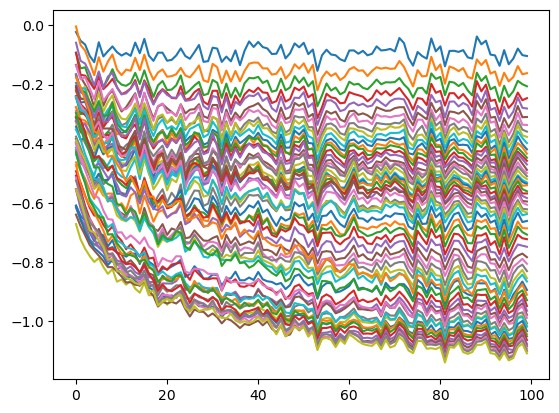

In [ ]:

for i in range(n-1, 0, -1):
    values = [t.item() for t in losses[i]]
    plt.plot(range(100),values[:100], label=i)

#plt.legend()

In [ ]:
def get_lower_bound_fbm():
  total_paths = 4096
  X_test = generate_fbm_markov(H,n, total_paths, device=device).to(device)
  g_val = g_fbm(X_test, total_paths).to(device)
  #X_test = torch.from_numpy(X_test).float().to(device)
  #g_val = torch.from_numpy(g_val).float().to(device)
  g_val_ext = g_val[:, :, np.newaxis]
  Z = g_val[range(total_paths), l[1](X_test, g_val_ext)]
  price = 1 / total_paths * torch.sum(Z)
  return price, torch.std(Z)/np.sqrt(total_paths)

In [ ]:
H_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
lower_bounds = []
stds = []
times = []
n = 50
d = n
learning_rate = 0.001
training_steps = 500
batch_size = 1024
total_paths = batch_size*training_steps

for H in H_values:

  X = generate_fbm_markov(H, n, total_paths, device=device).to(device)
  X = X.reshape(training_steps, batch_size, n+1, n)

  f = {n : fN}
  F = {n : FN}
  l = {n : lN}
  t = time.time()
  batch_train_fbm(X, F, f, l)
  print("Testing Time...")
  price, std_price = get_lower_bound_fbm()
  t2 = time.time()
  print(H, price, std_price, t2-t)
  lower_bounds.append(price)
  stds.append(std_price)
  times.append(t2-t)


In [ ]:
plt.plot(H_values, lower_bounds)
plt.title(r"Lower Bound Estimates for $sup_{\tau \in \{0,t_1,...,1\}}E W_{\tau}^H$")
plt.xlabel(r'$H$')
plt.ylabel(r'$\hat{L}$')
plt.grid(True)
plt.tight_layout()
plt.savefig("lower_bounds.pdf", format="pdf")

#### Longstaff-Schwartz Method

In [25]:
q = 0.1
r = 0.05
sigma = 0.2
n_steps = 9
n_sim   = 100000
T = 3
K = 100
S0 = 90

# Bermudan option parameters
n_evaluation_times = 9
n_sub_steps = n_steps // n_evaluation_times 

In [26]:
def sim_paths(q, S0, sigma, r, T, n_steps, n_sim): 
    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)
    
    BM_paths = np.random.normal(0, np.sqrt(dt), size=(n_sim, n_steps)).cumsum(axis=1)
    BM_paths = np.concatenate((np.zeros((n_sim, 1)), BM_paths), axis=1)
    
    St = S0 * np.exp((r - q - 0.5 * sigma**2) * times + sigma * BM_paths)
    
    return St

In [27]:
   
def General_Payoff(St, K, idx, type_, barrier=None, barrier_type=None):
   
    S_now = St[idx]
    S_path = St[:idx+1]
    
    # Handle barrier conditions
    if barrier is not None and barrier_type is not None:
        if barrier_type == "up-out" and np.any(S_path >= barrier):
            return 0.0
        if barrier_type == "down-out" and np.any(S_path <= barrier):
            return 0.0
        if barrier_type == "up-in" and not np.any(S_path >= barrier):
            return 0.0
        if barrier_type == "down-in" and not np.any(S_path <= barrier):
            return 0.0

    if type_ == "EuropeanCall":
        return max(S_now - K, 0)
    elif type_ == "EuropeanPut":
        return max(K - S_now, 0)
    elif type_ == "AsianCall":
        avg_price = np.mean(S_path)
        return max(avg_price - K, 0)
    elif type_ == "AsianPut":
        avg_price = np.mean(S_path)
        return max(K - avg_price, 0)
    else:
        raise ValueError("Unsupported option type")


def get_state_variable(St, i_eval, type_):

    if type_ in ["EuropeanCall", "EuropeanPut"]:
        return St[i_eval]
    elif type_ in ["AsianCall", "AsianPut"]:
        return np.mean(St[:i_eval+1])
    else:
        return St[i_eval]
    

In [28]:
def Bermudan_Option_LSM_Value(n_steps, n_evaluation_times, n_sub_steps, St, r, sigma,S0, K, T, payoff_fun, type_, d, barrier, barrier_type):
    
    # define simulation and time grids
    N = St.shape[0]
    bermudan_times = np.linspace(0, T, n_evaluation_times + 1)

    # define terminal payoffs
    Y  = [payoff_fun(St=St[i_sim, :], K=K, idx=n_steps, type_=type_,barrier = barrier, barrier_type= barrier_type) for i_sim in range(N)]
    Y = np.array(Y)
    
    # store regressions for out of sample analysis
    i = 1
    regressors = []
    regression_times = []
    
    # loop over every bermudan time grid evaluation down to 0 included
    for i_eval in range(n_steps - n_sub_steps, -n_sub_steps, -n_sub_steps):
        
        # the time jump from last implementation
        delta_t = bermudan_times[-i] - bermudan_times[-(i + 1)]
        
        # the immediate payoff at this evaluation grid (payoffs can be Asian, Barrier, European style... we don't discriminate)
        exercise_payoff = np.array([
            payoff_fun(St=St[i_sim, :], K=K, idx=i_eval, type_=type_,barrier = barrier, barrier_type= barrier_type) for i_sim in range(N)
        ])
        
        # we only care about the in-the-money to estimate the continuation value. If not in the money, we continue de-facto
        in_the_money = np.where(exercise_payoff > 0)[0]
        if len(in_the_money) > 0:
            
            # the variable we care about might depend on whether we look at Asian or European options
            state = np.array([get_state_variable(St[i_sim, :], i_eval, type_) for i_sim in in_the_money])   
            
            # polynomials
            X = np.zeros((len(in_the_money), d))
            for pol_degree in range(d):
                X[:, pol_degree] = state ** pol_degree
                
            # Y is the payoff at t+1, discounted to the current evaluation time
            Y_train = Y[in_the_money] * np.exp(-r * delta_t)
            
            model = LinearRegression()
            model.fit(X, Y_train)
            predictions = model.predict(X)
            
            exercise_now = exercise_payoff[in_the_money] > predictions
            Y[in_the_money] = np.where(exercise_now,
                                        exercise_payoff[in_the_money],
                                        Y[in_the_money] * np.exp(-r * delta_t))
            regressors.append(model)
            
            bermudan_idx = len(bermudan_times) - (1 + i)
            regression_times.append((i_eval, i))

            
            i += 1
        else: 
            Y = Y*np.exp(-r*delta_t)
    
    option_value = np.mean(Y)
    
    return option_value, list(zip(regression_times[::-1], regressors[::-1]))[::-1]
    

In [29]:

def Bermudan_LSM_OutOfSample(regressors_with_times, St_new, payoff_fun, get_state_variable, K, r, type_,  barrier, barrier_type):
   
    # define simulation and time grids
    bermudan_times  = np.linspace(0, T, n_evaluation_times + 1)
    N = St_new.shape[0]
    
    # termainl payoffs with the new simulated data
    Y  = np.array([payoff_fun(St=St_new[i_sim, :], K=K, idx=n_steps, type_=type_,  barrier =barrier, barrier_type =barrier_type) for i_sim in range(N)])


    # let's now go in the evaluation times when we had regressions in the training set.
    # Since some times did DO NOT HAVE REGRESSIONS, we have to make sure we discount correctly since we might have larger dsicount times
    # set future time step as the terminal point of the bermudan option
    future_time_step = n_evaluation_times
    
    
    for (i_eval, t_idx), model in regressors_with_times:
        
        delta_t = bermudan_times[future_time_step] - bermudan_times[i_eval]

        # immediate payoff
        exercise_payoff = np.array([
            payoff_fun(St=St_new[i_sim, :], K=K, idx=i_eval, type_=type_,barrier = barrier, barrier_type= barrier_type) for i_sim in range(N)
        ])

        in_the_money = np.where(exercise_payoff > 0)[0]
        
        if len(in_the_money) == 0:
            Y = Y * np.exp(-r * delta_t)
        else:
            state = np.array([get_state_variable(St_new[i_sim, :], i_eval, type_) for i_sim in in_the_money])   
            
            d = model.coef_.shape[0]
            X = np.column_stack([state ** p for p in range(d)])
            continuation = model.predict(X)
    
            exercise_now = exercise_payoff[in_the_money] > continuation
            Y[in_the_money] = np.where(exercise_now,
                                       exercise_payoff[in_the_money],
                                       Y[list(in_the_money)] * np.exp(-r * delta_t))
        
        future_time_step = i_eval
        
    option_value = np.mean(Y) * np.exp(-r *(future_time_step- 0))

    return option_value



In [30]:
start_in = time.time()

paths = sim_paths(q, S0, sigma, r, T, n_steps, n_sim)
payoff = General_Payoff

in_val, reg_dates = Bermudan_Option_LSM_Value(
    n_steps=n_steps,
    n_evaluation_times=n_evaluation_times,
    n_sub_steps=n_sub_steps,
    St=paths,
    r=r,
    sigma=sigma,
    S0=S0,
    K=K,
    T=T,
    payoff_fun=payoff,
    type_="EuropeanCall",
    d=3,
    barrier=None,
    barrier_type=None
)

end_in = time.time()
print(f"In-sample value:     {in_val:.4f}")
print(f"In-sample time:      {end_in - start_in:.4f} seconds")
print(f"# of regressions:    {len(reg_dates)}")


start_out = time.time()

St_new = sim_paths(q, S0, sigma, r, T, n_steps, n_sim)

out_val = Bermudan_LSM_OutOfSample(
    regressors_with_times=reg_dates,
    St_new=St_new,
    payoff_fun=payoff,
    get_state_variable=get_state_variable,
    K=K,
    r=r,
    type_="EuropeanCall",
    barrier=None,
    barrier_type=None
)

end_out = time.time()
print(f"Out-of-sample value: {out_val:.4f}")
print(f"Out-of-sample time:  {end_out - start_out:.4f} seconds")

In-sample value:     4.5223
In-sample time:      1.1866 seconds
# of regressions:    8
Out-of-sample value: 4.3847
Out-of-sample time:  0.8999 seconds


In [32]:
def binomial_tree_bermudan_general(S0, K, T, r, sigma, N, exercise_times, payoff_fun, type_, barrier=None, barrier_type=None):
    """
    raw dog that thang  - super intensive computaitonally !!! 
    """
    
    
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)


    asset_paths = [[[] for _ in range(i + 1)] for i in range(N + 1)]
    for i in range(N + 1):
        for j in range(i + 1):
            price_path = [S0]
            for step in range(1, i + 1):
                if step <= j:
                    price_path.append(price_path[-1] * d)
                else:
                    price_path.append(price_path[-1] * u)
            asset_paths[i][j] = price_path

    option_values = np.zeros((N + 1, N + 1))
    for j in range(N + 1):
        St = asset_paths[N][j]
        option_values[j, N] = payoff_fun(St, K, idx=N, type_=type_, barrier=barrier, barrier_type=barrier_type)

    # Backward induction 
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation = np.exp(-r * dt) * (
                q * option_values[j, i + 1] + (1 - q) * option_values[j + 1, i + 1]
            )
            if i in exercise_times:
                St = asset_paths[i][j]
                exercise = payoff_fun(St, K, idx=i, type_=type_, barrier=barrier, barrier_type=barrier_type)
                option_values[j, i] = max(continuation, exercise)
            else:
                option_values[j, i] = continuation

    return option_values[0, 0]

In [33]:
def estimate_martingale(St, regressors_with_times, get_state_variable, r, type_, barrier, barrier_type):
    bermudan_times = np.linspace(0, T, n_evaluation_times + 1)
    M = np.zeros(n_steps + 1)
    future_time_step = n_evaluation_times

    for (i_eval, t_idx), model in regressors_with_times:
        delta_t = bermudan_times[i_eval + 1] - bermudan_times[i_eval]
        
        x = get_state_variable(St, i_eval, type_)
        d = model.coef_.shape[0]
        X = np.array([x ** p for p in range(d)]).reshape(1, -1)
        continuation = model.predict(X)[0]

        prev_x = get_state_variable(St, i_eval + 1, type_) 
        X_next = np.array([prev_x ** p for p in range(d)]).reshape(1, -1)
        continuation_next = model.predict(X_next)[0] 

        delta_M = continuation - np.exp(-r * delta_t) * continuation_next
        M[i_eval] = M[i_eval + 1] + delta_M

    return M

S0_list = [90, 100, 110]
q = 0.1
r  = 0.05
sigma = 0.2
K = 100
T = 3
n_steps = 9
K_l = 1
K_u = 15
n_sim = 100000

# Bermudan option parameters
n_evaluation_times = 9
n_sub_steps = n_steps // n_evaluation_times 
payoff = General_Payoff

point_estimates = []
times_L = []
times_U = []
L_hats = []
U_hats = []
for S0 in S0_list: 
    
    np.random.seed(1)
    
    
    # 1 - construct point esitmate
    paths_tmp = sim_paths(q, S0, sigma, r, T, n_steps, n_sim)
    point_esitmate, regression_info = Bermudan_Option_LSM_Value(n_steps, n_evaluation_times, 
                                                                n_sub_steps, paths_tmp, r, 
                                                                sigma,S0, K, T, payoff, type_ = "EuropeanCall", 
                                                                d = 3, barrier = None, barrier_type= None)

    # 2 - estimate lower bound L_hat
    L_bound_sim = []
    
    start_time = time.time() 

    for k_l_sim in range(K_l): 
        St_new = sim_paths(q, S0, sigma, r, T, n_steps, n_sim)
        
        L_bound_tmp = Bermudan_LSM_OutOfSample(
            regressors_with_times=regression_info,
            St_new=St_new,
            payoff_fun=payoff,
            get_state_variable=get_state_variable,
            K=K, r=r, type_="EuropeanCall", 
            barrier = None, barrier_type= None
        )
        L_bound_sim.append(L_bound_tmp)
        
    L_hat = np.mean(L_bound_sim)
    end_time = time.time()
    
    L_hat_time = np.round(end_time- start_time,2)
    
    
    # 3- esimtate upper bound hat U-hat
    U_bound_sim = []
    start_time = time.time() 

    for k_u_sim in range(K_u): 
        St_path = sim_paths(q, S0, sigma, r, T, n_steps, 1)[0]  
        M_n = estimate_martingale(St_path, regression_info, get_state_variable, r, "EuropeanCall", None, None)
    
        g_adjusted = [General_Payoff(St_path, K, idx, "EuropeanCall") - M_n[idx] for idx in range(n_steps + 1)]
        U_bound_sim.append(max(g_adjusted))
        
    U_hat = np.mean(U_bound_sim)
    end_time = time.time()
    U_hat_time = np.round(end_time- start_time,2)
    
    times_L.append(L_hat_time)
    times_U.append(U_hat_time)
    U_hats.append(U_hat)
    L_hats.append(L_hat)
    point_estimates.append(point_esitmate)

print("L_hat times:", times_L)
print("U_hat times:", times_U)
print("L_hat values:", L_hats)
print("U_hat values:", U_hats)
print("Point estimates:", point_estimates)

L_hat times: [0.93, 0.98, 1.13]
U_hat times: [0.02, 0.01, 0.02]
L_hat values: [4.366217944935327, 7.801889052524365, 13.200258896357123]
U_hat values: [6.604486602387732, 9.596633796955022, 13.793599527411526]
Point estimates: [4.541096891966259, 8.121933704406691, 13.24388490458476]
